In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
BN_MOMENTUM=0.1
class Simple1DCNN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(5, 32*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(32*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(32*n, 32*n, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(32*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(32*n, 64*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(64*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(64*n, 64*n, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(64*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(64*n, 128*n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )
        self.conv6 = nn.Sequential(
            nn.Conv1d(128*n, 128*n, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(128*n, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
        )
        self.linear1 = nn.Sequential(
            nn.Linear(128*n*8,128*n*8),
            nn.ReLU(),
            nn.Linear(8*128*n,8*32*n),
            nn.ReLU(),
            nn.Linear(8*32*n,2)
        )

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    def forward(self, x):
        x=x.to(self.device)
        x= torch.transpose(x,1,2)
        x= self.conv1(x)
        x= self.conv2(x)
        x= self.conv3(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x=x.view(x.size(0),-1)
        x= self.linear1(x)
        return x

In [ ]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, data, break_points, labels):
        super().__init__()
        self.data = data[:,:,:5]
        self.break_points = break_points
        self.labels = labels
        
        self.zeropadded_data = self.data[:, :59, :]
        for ind, break_point in tqdm.tqdm(enumerate(break_points)):
            self.zeropadded_data[ind, break_point+1:] = self.zeropadded_data[ind,break_point]

        self.zeropadded_data = self.zeropadded_data.astype(float)
        for i in range(len(self.data)):
          max = np.max(self.zeropadded_data[i,:,4])
          self.zeropadded_data[i,:,4]= self.zeropadded_data[i,:,4]/max
          
        self.zeropadded_data[:, :, :4] = self.zeropadded_data[:, :, :4] / np.expand_dims(np.tile(np.expand_dims(self.zeropadded_data[:, 0, 0], axis=1), (1,59)), axis=2)

    def __getitem__(self, idx):
        return self.zeropadded_data[idx], self.labels[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
train_data = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_data_눌림목오전.npy')
val_data = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_data_눌림목오전.npy')
test_data = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_data_눌림목오전.npy')

train_labels = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_labels_눌림목오전.npy')
val_labels = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_labels_눌림목오전.npy')
test_labels = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_labels_눌림목오전.npy')

train_break_points = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/train_nullim_points_눌림목오전.npy')
val_break_points = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/val_nullim_points_눌림목오전.npy')
test_break_points = np.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/data/test_nullim_points_눌림목오전.npy')

In [ ]:
train_labels.sum() / train_labels.__len__(), train_labels.sum(), train_labels.__len__(), train_labels.__len__() - train_labels.sum()

(0.5916784203102962, 1678, 2836, 1158)

In [ ]:
train_part1 = train_data[np.arange(train_labels.shape[0])[(train_labels == 0)][:1460]]
train_part2 = train_data[train_labels == 1]
train_bp_1 = train_break_points[np.arange(train_labels.shape[0])[(train_labels == 0)][:1460]]
train_bp_2 = train_break_points[train_labels == 1]

In [ ]:
train_break_points = np.concatenate((train_bp_1, train_bp_2), axis=0)
train_labels = np.concatenate((np.ones(1460),np.zeros(1460)), axis=0)
train_data = np.concatenate((train_part1, train_part2), axis=0)

In [ ]:
train_break_points.shape, train_labels.shape, train_data.shape

((2920,), (2920,), (2920, 119, 8))

In [ ]:
val_labels.sum() / val_labels.__len__()

0.35490196078431374

In [ ]:
train_dataset = StockDataset(train_data, train_break_points, train_labels)
val_dataset = StockDataset(val_data, val_break_points, val_labels)
test_dataset = StockDataset(test_data, test_break_points, test_labels)

2836it [00:00, 333971.03it/s]
351it [00:00, 73036.70it/s]
316it [00:00, 75893.27it/s]


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
train_dataloader2 = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
print(train_dataset[17][0][0])

[1.         1.00306573 1.         1.00306573 0.06883918]


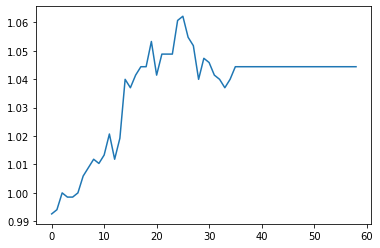

In [ ]:
plt.plot(train_dataset[17][0][:59,3])

In [ ]:
k=1
while(k):
  model = Simple1DCNN(1).to('cuda')
  #model = SimpleTransformer().to('cuda')
  loss_fn = nn.CrossEntropyLoss(reduction='none')#
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
  for epoch in range(50):
      epoch_loss = []
      sum_acc=0
      total_cnt=0
      iterate = 0
      model.train()
      for data,gt in train_dataloader:
          data = data.float()
          out=model(data)
          #gt = torch.tensor(gt, dtype=torch.long).to('cuda')
          gt = gt.to('cuda')
          loss = loss_fn(out,gt)
          c=torch.argmax(out,dim=1)
          '''
          for i in range(len(c)):
            if c[i]==1:
              loss[i]*=3
          '''
          loss = loss.mean()
          loss.backward()
          optimizer.zero_grad()
          optimizer.step()
          epoch_loss.append(loss)
          sum_acc+=torch.sum(c==gt)
          iterate+=1
          total_cnt+=len(gt)
      print("current epoch{} - train accuracy : {}".format(epoch,sum_acc/total_cnt))
      model.eval()
      outs = []
      with torch.no_grad():
          sum_acc=0
          total_cnt=0
          profit_correct=0
          loss_correct=0
          iterate = 0
          
          for i, (data, gt) in enumerate(val_dataloader):
              data = data.float()
              out=model(data)
              gt = gt.to('cuda')
              loss = loss_fn(out,gt)
              loss = loss.mean()
              c=torch.argmax(out,dim=1)
              sum_acc+=torch.sum(c==gt)
              iterate+=1
              total_cnt+=len(gt)
              outs += c.cpu().detach().numpy().tolist()
          
      TP = np.logical_and((val_labels == 1), (np.array(outs) == 1)).sum()
      FP = np.logical_and((val_labels == 0), (np.array(outs) == 1)).sum()
      winrate= TP/(TP+FP)
                  # outs = np.concatenate((outs, out.cpu().detach().numpy()), axis=0)
      print("current epoch{} - valid accuracy : {}, loss: {}, win rate: {}, buy #: {}".format(epoch,sum_acc/total_cnt, loss,winrate, (TP+FP)/351))
      if ((TP+FP)/351<=0.1 or (TP+FP)/351>=0.7):
        break
      if epoch>5 and winrate<0.59:
        break
      if (sum_acc/total_cnt>0.53) and (winrate > 0.63) and (TP+FP)/351>0.30:
        torch.save(model,'/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/best_model_0809.pt')
        k=0
        break

current epoch0 - train accuracy : 0.5909091234207153
current epoch0 - valid accuracy : 0.5840455889701843, loss: 0.6990327835083008, win rate: 0.584045584045584, buy #: 1.0
current epoch0 - train accuracy : 0.4378551244735718
current epoch0 - valid accuracy : 0.4245014190673828, loss: 0.6936880350112915, win rate: 0.5454545454545454, buy #: 0.09401709401709402
current epoch0 - train accuracy : 0.4076704680919647
current epoch0 - valid accuracy : 0.4159544110298157, loss: 0.6926811933517456, win rate: nan, buy #: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in long_scalars


current epoch0 - train accuracy : 0.54296875
current epoch0 - valid accuracy : 0.5698005557060242, loss: 0.6952744722366333, win rate: 0.5794117647058824, buy #: 0.9686609686609686
current epoch0 - train accuracy : 0.42258524894714355
current epoch0 - valid accuracy : 0.41310539841651917, loss: 0.691816508769989, win rate: 0.3333333333333333, buy #: 0.008547008547008548
current epoch0 - train accuracy : 0.42294034361839294
current epoch0 - valid accuracy : 0.43589743971824646, loss: 0.6958973407745361, win rate: 0.5315315315315315, buy #: 0.3162393162393162
current epoch1 - train accuracy : 0.42471593618392944
current epoch1 - valid accuracy : 0.4444444477558136, loss: 0.6926288604736328, win rate: 0.6190476190476191, buy #: 0.11965811965811966
current epoch2 - train accuracy : 0.42862218618392944
current epoch2 - valid accuracy : 0.4444444477558136, loss: 0.692293643951416, win rate: 0.6136363636363636, buy #: 0.12535612535612536
current epoch3 - train accuracy : 0.4275568425655365
cu

In [ ]:
model.eval()
outs = []
with torch.no_grad():
    sum_acc=0
    total_cnt=0
    profit_correct=0
    loss_correct=0
    iterate = 0
    
    for i, (data, gt) in enumerate(test_dataloader):
        data = data.float()
        out=model(data)
        gt = gt.to('cuda')
        c=torch.argmax(out,dim=1)
        outs += c.cpu().detach().numpy().tolist()
    
TP = np.logical_and((test_labels == 1), (np.array(outs) == 1)).sum()
FP = np.logical_and((test_labels == 0), (np.array(outs) == 1)).sum()
FN = np.logical_and((test_labels == 1), (np.array(outs) == 0)).sum()
TN = np.logical_and((test_labels == 0), (np.array(outs) == 0)).sum()
winrate= TP/(TP+FP)
print(winrate)
print("TP : ",TP," FP : ",FP," FN : ",FN," TN : ",TN,)

0.5944444444444444
TP :  107  FP :  73  FN :  88  TN :  48


In [ ]:
model.eval()
outs = []
with torch.no_grad():
    sum_acc=0
    total_cnt=0
    profit_correct=0
    loss_correct=0
    iterate = 0
    
    for i, (data, gt) in enumerate(train_dataloader2):
        data = data.float()
        out=model(data)
        gt = gt.to('cuda')
        c=torch.argmax(out,dim=1)
        outs += c.cpu().detach().numpy().tolist()
    
TP = np.logical_and((train_labels == 1), (np.array(outs) == 1)).sum()
FP = np.logical_and((train_labels == 0), (np.array(outs) == 1)).sum()
FN = np.logical_and((train_labels == 1), (np.array(outs) == 0)).sum()
TN = np.logical_and((train_labels == 0), (np.array(outs) == 0)).sum()
winrate= TP/(TP+FP)
print(winrate)
print("TP : ",TP," FP : ",FP," FN : ",FN," TN : ",TN,)

0.6083565459610027
TP :  1092  FP :  703  FN :  586  TN :  455


In [ ]:
torch.save(model,'/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/best_model_p16_l10_618_549.pt')

In [ ]:
m=torch.load('/content/drive/MyDrive/인공지능 온라인 경진대회/주식/model/best_model_p16_l10_58.pt')
outs=[]
smdiffs=[]
with torch.no_grad():
    sum_acc=0
    total_cnt=0
    profit_correct=0
    loss_correct=0
    iterate = 0
    sm=nn.Softmax(dim=1)
    for i, (data, gt) in enumerate(test_dataloader):
        data = data.float()
        out=m(data)
        gt = gt.to('cuda')
        smdiffs+=(sm(out)[:,0]-sm(out)[:,1]).cpu().detach().numpy().tolist()
        c=torch.argmax(out,dim=1)
        outs += c.cpu().detach().numpy().tolist()

        
TP = np.logical_and((test_labels == 1), (np.array(outs) == 1)).sum()
FP = np.logical_and((test_labels == 0), (np.array(outs) == 1)).sum()
FN = np.logical_and((test_labels == 1), (np.array(outs) == 0)).sum()
TN = np.logical_and((test_labels == 0), (np.array(outs) == 0)).sum()
winrate= TP/(TP+FP)
print(winrate)
print("TP : ",TP," FP : ",FP," FN : ",FN," TN : ",TN,)


0.5803571428571429
TP :  65  FP :  47  FN :  93  TN :  88
